In [24]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Coördinaten Nederland (bijv. De Bilt)
latitude = 52.1
longitude = 5.18

# Open-Meteo API call
url = (
    f"https://api.open-meteo.com/v1/forecast?"
    f"latitude={latitude}&longitude={longitude}"
    f"&hourly=temperature_2m,precipitation,shortwave_radiation,"
    f"direct_radiation,diffuse_radiation,wind_speed_10m,wind_direction_10m,wind_gusts_10m"
)

# Request
response = requests.get(url)
data = response.json()

# DataFrame maken
forecast_df = pd.DataFrame(data['hourly'])
forecast_df['time'] = pd.to_datetime(forecast_df['time'])

# Filter: alleen komende 24 uur
now = datetime.now()
next_24h = now + timedelta(hours=24)

forecast_24h = forecast_df[(forecast_df['time'] >= now) & (forecast_df['time'] <= next_24h)]



print(forecast_df.columns)


Index(['time', 'temperature_2m', 'precipitation', 'shortwave_radiation',
       'direct_radiation', 'diffuse_radiation', 'wind_speed_10m',
       'wind_direction_10m', 'wind_gusts_10m'],
      dtype='object')


Index(['time', 'temperature_2m', 'precipitation', 'shortwave_radiation',
       'direct_radiation', 'diffuse_radiation', 'wind_speed_10m',
       'wind_direction_10m', 'wind_gusts_10m', 'hour', 'day_of_week', 'month',
       'is_weekend', 'is_holiday', 'T', 'cooling_degree', 'heating_degree'],
      dtype='object')


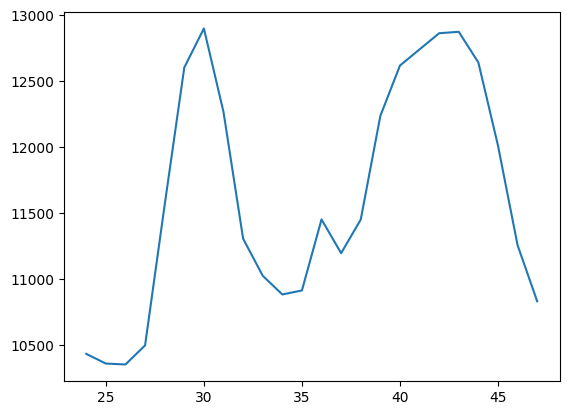

In [30]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt


selected_features = [
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_holiday', 'T',
      'heating_degree', 'cooling_degree'    
]

def prepare_forecast_features(forecast_df):
    df = forecast_df.copy()
    df['hour'] = df['time'].dt.hour
    df['day_of_week'] = df['time'].dt.weekday  # Maandag=0, Zondag=6
    df['month'] = df['time'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # Zaterdag of Zondag = 1
    df['is_holiday'] = 0  # Kan je aanpassen met echte feestdagen als je wilt

    df['T'] = forecast_24h['temperature_2m']*10

    # Cooling en heating degree days (optioneel, afhankelijk van je model)
    df['cooling_degree'] = (df['temperature_2m'] - 18).clip(lower=0)
    df['heating_degree'] = (18 - df['temperature_2m']).clip(lower=0)

    # Drop originele 'time' kolom als je model dat niet nodig heeft
    # Of houd hem als je timestampstamps wilt bewaren
    return df

# Gebruik:
forecast_ready = prepare_forecast_features(forecast_24h)

print(forecast_ready.columns)

# 1. Model laden
with open('best_xgb_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# 2. Features selecteren
X_forecast = forecast_ready[selected_features]

# 3. Load voorspellen
forecast_predictions = loaded_model.predict(X_forecast)

# 4. Resultaat toevoegen
forecast_ready['predicted_load'] = forecast_predictions

forecast_ready['timestamp'] = forecast_ready['time']


plt.plot(forecast_ready['predicted_load'])

# Forecast klaarmaken voor model input



In [35]:
a = forecast_ready[['timestamp', 'predicted_load', 'T']]

In [36]:
with open('first_forecast.pkl', 'wb') as file:

    pickle.dump(a, file)